# Лекция 10

## Итерационные методы и предобуславливатели

## На прошлой лекции

- Процесс Арнольди для ортогонализации Крыловского подпространства
- Процесс Ланцоша в симметричном случае
- Функционал энергии и метод сопряжённых градиентов
- Анализ сходимости
- Случай несимметричной системы: идея метода GMRES

## План на сегодня

- Другие итерационные методы: MINRES, BiCG и BiCGStab 
- Концепция предобуславливателей

## Какой метод использовать?

- Если матрица симметричная (эрмитова) и положительно определённая, используйте метод сопряжённых градиентов.
- Если матрица симметричная, но не определённая, можем использовать метод MINRES (идея GMRES, применённая к симметричной системе, подробности далее)
- Если матрица несимметричная и не очень большая, используйте GMRES
- Если матрица несимметричная и мы можем хранить только ограниченное число векторов, используем либо GMRES с рестартами, либо BiCGStab (требуется также функция умножения на $A^{\top}$).

### Более детальный план по выбору метода из [этой книги](http://www.netlib.org/templates/templates.pdf)
<img src="./flowchart_iterative_methods.png">

## MINRES

Метод MINRES – это GMRES, применённый к симметричной матрице системы. Мы минимизируем

$$\Vert A Q_j x_j - f \Vert_2 = \Vert Q_j \widehat{x}_j + h_{j, j-1} q_j \widehat{x}_j - f \Vert_2 = \Vert Q_{j+1} \widehat{H}_{j+1}  \widehat{x}_j - f \Vert_2 \rightarrow \min$$

что эквивалентно линейной задаче наименьших квадратов с **почти трёхдиагональной** матрицей

$$\Vert \widehat{H}_{j+1} x_{j} - \gamma e_0 \Vert_2 \rightarrow \min.$$

- По аналогии с GMRES мы можем получить короткие рекуррентные соотношения

- Аккуратная реализация MINRES требует хранить не более $5$ векторов

## Отличия между MINRES и CG

- MINRES минимизирует $\Vert Ax_k - f \Vert_2$ на Крыловском подпространстве
- CG минимизирует $(Ax, x) - 2(f, x)$ на Крыловском подпространстве
- MINRES применим к неопределённым (то есть не положительно определённым) задачам.
- CG хранит меньше векторов ($3$ вместо $5$). 

Теперь перейдём к обсуждению несимметричных систем.

## Несимметричные системы

- Основной недостаток GMRES: нам нужно хранить все векторы, поэтому с каждой итерацией нужно всё больше и больше памяти

- Мы можем делать  **рестарты** (то есть вычислить новый вектор невязки и строить новое Крыловское подпространство на его основе): мы нашли некоторое приближённое решение $x$ и теперь решаем новую линейную систему на вектор коррекции:

$$A(x + e) = f, \quad Ae = f - Ax,$$

и генерируем новое **Крыловское подпространство** из данного вектора невязки. Это замедляет сходимость, что мы покажем далее.

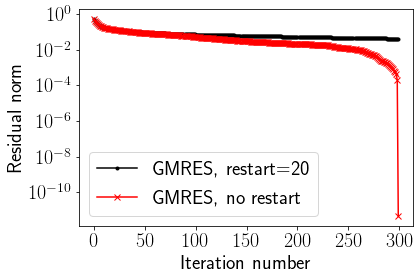

In [1]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import numpy as np
import scipy as sp

n = 300
ex = np.ones(n);
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)

res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r))
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r))

small_restart = 20
sol = scipy.sparse.linalg.gmres(A, rhs, restart=small_restart, callback=gmres_rst_cl)
sol = scipy.sparse.linalg.gmres(A, rhs, restart=n, callback=gmres_rst)

lim = 300
plt.semilogy(res_gmres_rst[:lim], marker='.',color='k', label='GMRES, restart={}'.format(small_restart))
plt.semilogy(res_gmres[:lim], marker='x',color='r', label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

### Как избежать такого замедления сходимости?

- Метод бисопряжённых градиентов (biconjugate gradient method, название **BiCG** предложено Fletcher'ом, [оригинальная статья](https://link.springer.com/chapter/10.1007%2FBFb0080116)) позволяет избежать замедления сходимости с помощью "коротких рекуррентных соотношений" по аналогии с CG.

## Идея метода бисопряжённых градиентов

- Используем нормальное уравнение:

$$A^* A x = A^* f,$$

и применяем CG для его решения.

- Число обусловленности равно квадрату числа обусловленности для исходной матрицы, поэтому нам нужна процедура **стабилизации**.

- Стабилизация приводит к повышению устойчивости (подробности далее)

На следующем примере покажем неустойчивость метода бисопряжённывх градиентов для несимметричной матрицы.

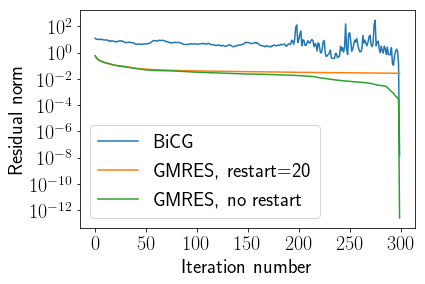

In [12]:
res_all_bicg = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))
    
sol = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(n), callback=bicg_cl)
plt.semilogy(res_all_bicg, label='BiCG')
plt.semilogy(res_gmres_rst[:n], label='GMRES, restart=20')
plt.semilogy(res_gmres, label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

##  Бисопряжённые градиенты

У нас есть два варианта:

1. Использовать $\mathcal{K}(A^* A, A^* f)$ для генерации подпространства, но это приводит к увеличению числа обусловленности
2. Вместо этого можем использовать Крыловские подпространства $\mathcal{K}(A)$ и $\mathcal{K}(A^*)$ для генерации двух базисов, которые будут **биортогональны** (так называемый биортогональный процесс Ланцоша).

- Цель: вычислить проекцию Петрова-Галёркина исходной матрицы

$$W^* A V \widehat{x} = W^* f$$

со столбцами $W$ из Крыловского подпространства для матрицы $A^*$, и $V$ – для матрицы $A$ (сравните с CG). 

- Это может привести к неустойчивости, если мы будем пересчитывать решение наиболее эффективным образом.

## BiCG метод

На практике для реализации метода BiCG используют **двусторонний процесс Ланцоша**: генерирование Крыловского подпространства для $A$ и $A^{\top}$.

В частности,

1. $\alpha_j = \frac{(r_j, \hat{r}_j)}{(Ap_j, \hat{p}_j)}$
2. $x_{j+1} = x_j + \alpha_j p_j $
3. $r_{j+1} = r_j - \alpha_j Ap_j$
4. $\hat{r}_{j+1} = \hat{r}_j - \alpha_j A^{\top}\hat{p}_j$
5. $\beta_j = \frac{(r_{j+1}, \hat{r}_{j+1})}{(r_j, \hat{r}_j)}$
6. $p_{j+1} = r_{j+1} + \beta_j p_j$
7. $\hat{p}_{j+1} = \hat{r}_{j+1} - \beta_j \hat{p}_j$

Далее рассмотрим устойчивую версию метода BiCG.

## BiCGStab

- BiCGStab часто используется и представляет из себя **стабилизированную** версию методу BiCG. Он обладает более быстрой и гладкой сходимостью, чем оригинальный метод BiCG.

- Формулы можно посмотреть, например, [тут](https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method)

- Они являются комбинацией шага метода BiCG с последующим шагом GMRES(1) для сглаживания сходимости.

- Более подробно метод описан в книге ["Iterative Krylov Methods for Large Linear Systems"](http://www.lmn.pub.ro/~daniel/ElectromagneticModelingDoctoral/Books/Numerical%20Methods/VanDerVorst2003%20Iterative%20Krylov%20Methods%20for%20Large%20Linear%20Systems.pdf) за авторством H. Van-der Vorst.

Далее сравним сходимость стабилизированной и нестабилизированной версии метода BiCG

Dimension of the linear system = 90000


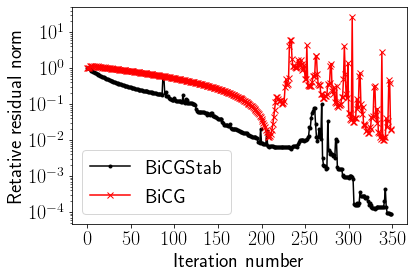

In [4]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

n = 300

# ex = np.ones(n);
# A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr') 
# rhs = np.random.randn(n)

ee = sp.sparse.eye(n)
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr')
A = sp.sparse.kron(A, ee) + sp.sparse.kron(ee, A)
rhs = np.ones(n * n)

print("Dimension of the linear system = {}".format(A.shape[0]))

res_all_bicg = []
res_all_bicgstab = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))

def bicgstab_cl(x):
    res_all_bicgstab.append(np.linalg.norm(A.dot(x) - rhs))

sol2 = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(A.shape[0]), callback=bicg_cl)
sol2 = scipy.sparse.linalg.bicgstab(A, rhs, x0=np.zeros(A.shape[0]), callback=bicgstab_cl)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]
res_all_bicgstab = np.array(res_all_bicgstab)/res_all_bicgstab[0]

lim = 350
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')

plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Retative residual norm', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

## "Нелинейный GMRES" или ускорение Андерсона

- Мы можем применить идею похожую на идею метода GMRES для ускорения сходимости произвольного метода неподвижной точки

$$x_{k+1} = \Phi(x_k).$$

- На самом деле такой подход был предложен задолго до метода GMRES, и известен в квантовой химии как "Direct Inversion in Iterated Subspaces", или **ускорение Андерсона**.

- Идея: **используем историю** для обновления

$$x_{k+1} = \Phi(x_k) + \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})), $$

а параметры $\alpha_s$ выбираются так, чтобы минимизировать норму невязки

$$ \min_{\alpha} \left \| \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})) \right\|_2, \quad \sum_{s=1}^m \alpha_s = 1$$

- Более подробно см. в [оригинальной работе](https://users.wpi.edu/~walker/Papers/Walker-Ni,SINUM,V49,1715-1735.pdf)

## Борьба с числом обусловленности

- Проблема большого числа обусловленности **непреодолима**, если доступна только процедура умножения матрицы на вектор.

- Поэтому для её решения нам нужны **предобуславливатели**.

- Существует несколько предобуславливателей, применимых для любой задачи, но часто для конкретной задачи нужен специально построенный предобуславливатель.

### Предобусловливатель: концепция

Дана линейная система 

$$A x = f,$$

мы хотим найти матрицу $P_R$ и/или $P_L$ такую что 

1. Число обусловленности $AP_R^{-1}$ (правый предобуславливатель) или $P^{-1}_LA$ (левый предобуславливатель) или $P^{-1}_L A P_R^{-1}$ меньше, чем у $A$
2. Мы можем быстро решать системы $P_Ly = g$ или $P_Ry = g$ для любых $g$ (иначе мы могли бы взять например $P_L = A$)

- Тогда мы решаем следующую систему (для правого предобуславливателя)

$$ AP_R^{-1} y = f \quad \Rightarrow \quad P_R x = y$$ 

или (для левого предобуславливателя)

$$ P_L^{-1} A x = P_L^{-1}f,$$ 

или для обоих 

$$ P_L^{-1} A P_R^{-1} y = P_L^{-1}f \quad \Rightarrow \quad P_R x = y.$$ 

- Лучший выбор, конечно, $P = A$, но он не делает жизнь проще (почему?)

- Одна из идей – это использовать другие итерационные меоды (помимо Крыловских) как предобуславливатели

### Другие итерационные методы как предобуславливатели

Существуют другие итерационные методы, которые мы ещё не упоминали. 

1. Метод Якоби
2. Метод Гаусса-Зейделя
3. SOR($\omega$) (Successive over-relaxation) и его симметричная модификация SSOR($\omega$)

### Метод Якоби (как предобуславливатель)

Рассмотрим матрицу с ненулевой диагональю. Для получения **метода Якоби** выразим диагональный элемент:

$$a_{ii} x_i = -\sum_{i \ne j} a_{ij} x_j + f_i$$

и используем это выражение для обновления $x_i$:

$$ x_i^{(k+1)} = -\frac{1}{a_{ii}}\left( \sum_{i \ne j} a_{ij} x_j^{(k)} + f_i \right),$$

или в матричной форме

$$ x^{(k+1)} = D^{-1}\left((D-A)x^{(k)} + f\right) $$

где $D = \mathrm{diag}(A)$ и наконец

$$ x^{(k+1)} = x^{(k)} - D^{-1}(Ax^{(k)} - f). $$

- Метод Якоби – это метод Ричардсона с $\tau=1$ и левым предобуславливателем $P = D$ – диагональной матрицей. 
- Поэтому мы будем называть $P = \mathrm{diag}(A)$ **предобуславливаталем Якоби**. 
- Отметим, что он может быть использован для других методов, например для метода Чебышёва или Крыловских методов.

### Свойства предобуславливателя Якоби

Предобуславливатель Якоби:

1. Очень прост для вычисления и использования
2. Хорошо работает для матриц с диагональным преобладанием (вспомните теорему о кругах Гершгорина!)
3. Бесполезен, если все диагональные элементы одинаковы (пропорционален единичной матрице)

### Метод Гаусса-Зейделя (как предобуславливатель)

- Другой хорошо известный метод – это **метод Гаусса-Зейделя**. 

- Его каноническая форма очень похожа на метод Якоби с одним небольшим отличием. Когда мы обновляем $x_i$

$$x_i^{(k+1)} := -\frac{1}{a_{ii}}\left( \sum_{j =1}^{i-1} a_{ij} x_j^{(k+1)} +\sum_{j = i+1}^n a_{ij} x_j^{(k)} - f_i \right)$$

мы **используем последние обновления предыдущих компонент**. В методе Якоби мы использовали весь вектор с прошлой итерации.

- Его матричная форма более сложная.

### Метод Гаусса-Зейделя: матричная форма

- Пусть дана матрица $A = A^{*} > 0$, для которой справедливо следующее представление  

$$A = L + D + L^{*},$$

где $D$ – диагональная часть матрицы $A$, $L$ – нижнетреугольная часть с нулями на диагонали.

- Одна итерация метода Гаусса-Зейделя записывается следующим образом

$$ x^{(k+1)} = x^{(k)} - (L + D)^{-1}(Ax^{(k)} - f) $$

и приводит нас к предобуславливателю $P = L+D$, который мы будем называть **предобуславливатель Гаусса-Зейделя**.

- **Хорошая новость:** $\rho(I - (L+D)^{-1} A) < 1, $ где $\rho$ – спектральный радиус, то есть для симметричной положительно определённой матрицы метод Гаусса-Зейделя сходится.

### Метод Гаусса-Зейделя и координатный спуск

- Метод Гаусса-Зейделя может быть рассмотрен как координатный спуск применённый к функционалу энергии

$$F(x) = (Ax, x) - 2(f, x).$$

- Одна итерация примет вид 

$$x_i := \arg \min_z F(x_1, \ldots, x_{i-1}, z, x_{i+1}, \ldots, x_d).$$

- Порядок исключения переменных очень важен!

## Successive overrelaxation (как предобуславливатель)

Далее добавим параметр $\omega$ в предобуславливатель Гаусса-Зейделя и получим метод **successive over-relaxation** (**SOR($\omega$)**):

$$ x^{(k+1)} = x^{(k)} - \omega (D + \omega L)^{-1}(Ax^{(k)} - f). $$

$$P = \frac{1}{\omega}(D+\omega L).$$

- Сходится для $0<\omega < 2$. 
- Оптимальный выбор $\omega$ – нетривиальная задача. Если метод Якоби сходится, то

$$\omega^* = \frac{2}{1 + \sqrt{1 - \rho_J^2}},$$ 

где $\rho_J$ – спектральный радиус в методе Якоби.
- Отметим, что $\omega = 1$ даёт предобуславливатель Гаусса-Зейделя.


### Предобуславливатели для разреженных матриц

- Если $A$ разрежена, то стоимость одной итерации метода Якоби, Гаусса-Зейделя и SOR низкая (какая сложность?). 

- В методе Гаусса-Зейделя нам нужно решить систему лийненых уравнений с треугольной матрицей $L$, что стоит $\mathcal{O}(nnz)$ операций.

- Однако для разреженных матриц есть более сложные и эффективные алгоритмы, основанные на идее **приближённого LU разложения**.

- Вспомним мотивацию в методе CG: возможность ранней остановки
- Как можно приблизить LU разложение для разреженной матрицы?

### Вспомним метод Гаусса


- Представить матрицу $A$ в виде 

$$A = P_1 L U P^{\top}_2, $$

где $P_1$ и $P_2$ определённые матрицы перестановок, с помощью которых производится выбор ведущего элемента

- Наиболее естественная идея – это использовать разреженные факторы $L$ и $U$

- Это невозможно из-за роста заполнения факторов для матриц, получаемых из дифференциальных уравнения в частных производных

- Что с этим делать?

### Неполное LU разложение

- Пусть вы хотите исключить переменную $x_1$ в следующих уравнениях

$$5 x_1 + x_4 + x_{10} = 1, \quad 3 x_1 + x_4 + x_8 = 0, \ldots,$$

и во всех других уравнениях $x_1$ отсутствует. 

- После исключения только $x_{10}$ дополнительно войдёт во второе уравнение (новый ненулевой элемент)

$$x_4 + x_8 + 3(1 - x_4 - x_{10})/5 = 0.$$

- В случае использования неполного $LU$ разложения (на самом деле, ILU(0)) мы просто отбрасываем новый ненулевой элемент.

## Неполное LU разложение: формальное определение

Используем стандартный цикл для LU разложения, но избегаем вставки новых ненулевых элементов в факторы. 

```python
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    for k in range(n): #Eliminate one row   
        L[k, k] = 1
        for i in range(k+1, n):
            L[i, k] = a[i, k] / a[k, k]
            for j in range(k+1, n):
                a[i, j] = a[i, j] - L[i, k] * a[k, j]  #New fill-ins appear here
        for j in range(k, n):
            U[k, j] = a[k, j]
```

## ILU(k)

- Yousef Saad (автор метода GMRES) также является автором [работы](https://www-users.cs.umn.edu/~saad/PDF/umsi-92-38.pdf) о **неполном LU разложении**

- Хорошая книга по этой теме – [Iterative methods for sparse linear systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf), Y. Saad, 1996

- Он также предложил метод **ILU(k)**, который имеет красивую интерпретацию в терминах графов.

## ILU(k): идея

- Идея ILU(k) основана на связи между разреженными матрицами и графами.

- Пусть дана матрица $n \times n$ и соответствующий её граф

- Тогда при исключении одной переменной (вершины) мы получим меньшую систему размера $(n-1) \times (n-1)$.

- Новое ребро (=новый ненулевой элемент) возникнет между соседями.

## LU & графы

- Новое ребро может возникнуть только между вершинами, у которых есть общие соседи: это означает, что они соседи второго порядка (соседи соседей)
- Это также шаблон разреженности матрицы $A^2$.
- Идея **ILU(k)** состоит в том, чтобы оставить в факторах $L$ и $U$ те ненулевые элементы, которые соответствуют соседям $k$-го порядка в исходном графе
- Метод ILU(2) очень эффективен, но по каким-то причинам игнорируется (например, его реализации нет ни в MATLAB, ни в SciPy).
- Есть оригинальный пакет [Sparsekit](https://people.sc.fsu.edu/~jburkardt/f_src/sparsekit/sparsekit.html) написанный Saad'ом, который работает достаточно хорошо.

## ILU Thresholded (ILUT)

- Гораздо более популярный подход основан на так называемом **thresholded LU**.

- Вы проводите стандартное исключение Гаусса с заполнением, но не учитываете элементы, которые меньше заданного порога (threshold), и/или контролируете количество ненулевых элементов, которые вы разрешаете хранить.

- Чем меньше значение порога, тем лучше предобуславливатель, но больше памяти требуется.

- Этот метод обозначается ILUT($\tau$).

### Случай симметричной положительно определённой матрицы

- В этом случае вместо неполного LU разложения, нужно использовать неполное разложение Холецкого, которое вдвое быстрее и требует вдвое меньше памяти.

### LU разложение второго порядка

- Существует более эффективный (но менее популярный в силу отсутствия удобной реализации с открытым кодом) метод под названием LU разложение второго порядка, [предложенное И. Капориным](http://www.researchgate.net/profile/I_Kaporin/publication/242940993_High_quality_preconditioning_of_a_general_symmetric_positive_definite_matrix_based_on_its_UTU__UTR__RTU-decomposition/links/53f72ad90cf2888a74976f54.pdf)

- Идея заключается в представлении матрицы в виде

$$A \approx U_2 U^{\top}_2 + U^{\top}_2 R_2 + R^{\top}_2 U_2,$$

что является разложением $UU^{\top}$ по отношению к возмущению $U$. 

- $U_1$ и $U_2$ верхнетреугольные и разреженные, в то время как матрица $R_2$ мала.



### Итерационные методы для других задач NLA 

- До сих пор мы обсуждали исключительно задачу решения системы линейных уравнений

- В то же время существуют другие важные задачи большой размерности:

    1. (Частичная) задача на собственные значения: $Ax_k = \lambda_k x_k.$
    2. (Частичное) вычисление SVD: $A v_k = \sigma_k u_k, \quad A^* u_k = \sigma_k v_k$.

- Предварительное замечание об этих задачах:
    - **Найти все собственные/сингулярные значения матрицы – очень сложная задача** (почему?)

    - Но возможно решить **частичную задачу на собственные значения**. 

    - Напомним, что алгоритм вычисления SVD был основан на симметричной задаче на собственные значения.

## Резюме

- Методы MINRES, BiCG и BiCGStab 
- Предобуславливатели: метод Якоби, Гаусса-Зейделя и SOR($\omega$)
- Неполное LU разложение и его варианты

In [41]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()